In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Define a simple model with two 3x3 convolutions
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        return x

# Function to extract patches from the feature map
def extract_patches(feature_map, patch_size):
    batch_size, channels, height, width = feature_map.size()
    patches = feature_map.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)
    return patches

# Class for learned positional embeddings
class PositionalEmbedding(nn.Module):
    def __init__(self, num_patches, dim):
        super(PositionalEmbedding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))

    def forward(self, x):
        return x + self.pos_embedding


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from utils.utils import load_image

In [6]:
image_path = "/home/linuxu/Documents/datasets/Tiny_LR/21.jpeg"
dummy_image = load_image(image_path)

Patch embeddings shape: torch.Size([1, 64, 64])


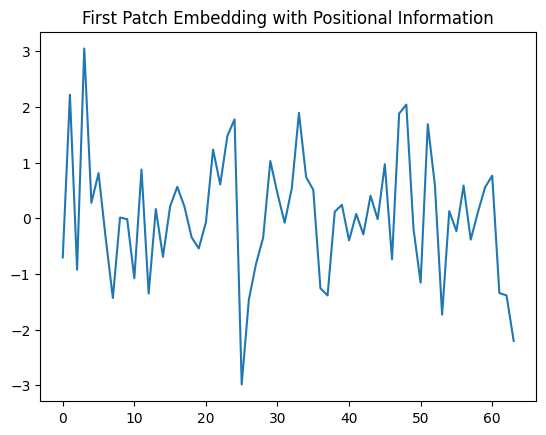

In [7]:
# Initialize model and create a dummy input image
model = SimpleCNN().to(device)
dummy_image = dummy_image.to(device)  # Example 32x32 RGB image

# Forward pass through the model
feature_map = model(dummy_image)

# Extract 4x4 patches from the feature map
patch_size = 8
patches = extract_patches(feature_map, patch_size)

# Flatten each patch and project to a fixed dimension
batch_size, channels, num_patches, _, _ = patches.shape
dim = 64  # Fixed dimension for patch embedding
patches = patches.view(batch_size, channels, num_patches, -1)  # Flatten each patch
patches = patches.permute(0, 2, 1, 3).contiguous()  # Move channels to the right position
patches = patches.view(batch_size, num_patches, -1)  # Final shape: (batch_size, num_patches, channels * patch_size^2)
patch_embeddings = nn.Linear(channels * patch_size * patch_size, dim).to(device)
patches = patch_embeddings(patches)  # Project to fixed dimension

# Add learned positional embeddings
pos_embedding_layer = PositionalEmbedding(num_patches=num_patches, dim=dim).to(device)
patches_with_pos = pos_embedding_layer(patches)

# Visualize the first patch embedding with positional information
print(f"Patch embeddings shape: {patches_with_pos.shape}")  # Should be (batch_size, num_patches, dim)

# Display the first patch embedding as an example
first_patch_embedding = patches_with_pos[0, 0, :].cpu().detach().numpy()
plt.plot(first_patch_embedding)
plt.title("First Patch Embedding with Positional Information")
plt.show()


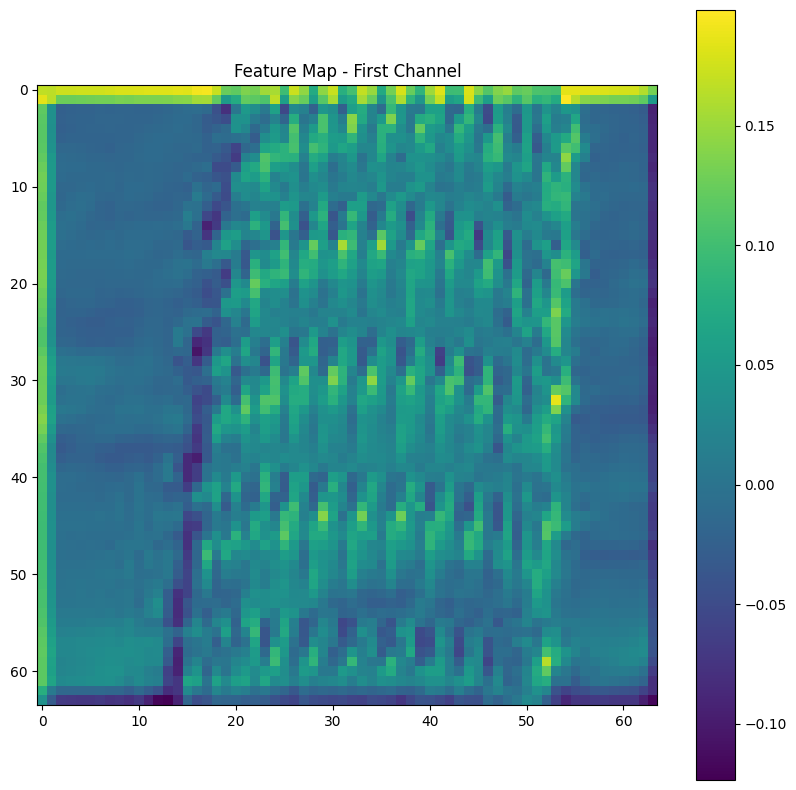

In [8]:
# Plot the first channel of the feature map
# (Since the feature map has many channels, we'll visualize just one)
plt.figure(figsize=(10, 10))
plt.imshow(feature_map[0, 0, :, :].cpu().detach().numpy(), cmap='viridis')
plt.title("Feature Map - First Channel")
plt.colorbar()
plt.show()

In [9]:
feature_map.shape

torch.Size([1, 64, 64, 64])

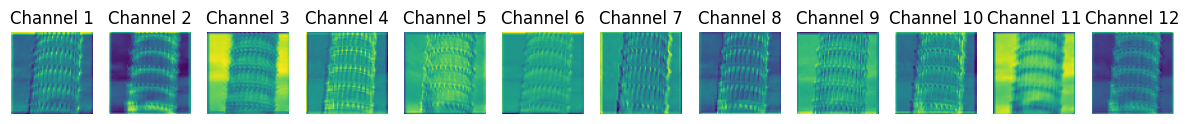

In [10]:
# Visualize multiple channels of the feature map
num_channels_to_plot = 12  # Number of feature map channels to plot
fig, axes = plt.subplots(1, num_channels_to_plot, figsize=(15, 5))

for i in range(num_channels_to_plot):
    ax = axes[i]
    ax.imshow(feature_map[0, i, :, :].cpu().detach().numpy(), cmap='viridis')
    ax.axis('off')
    ax.set_title(f"Channel {i+1}")

plt.show()

In [19]:
from model.maxsr_tiny import MaxSRTiny

In [12]:
# Test the MaxSR model with a dummy input
maxsr_model = MaxSRTiny().to(device)


In [13]:
output_image =maxsr_model(dummy_image)

In [14]:
output_image.shape

torch.Size([1, 3, 128, 128])